# Generate 2D embeddings to model the spatial characteristics of EEG and its semantics</h1>


**First Let's normalize the X and Y coordinate system in a way to the preserve X symmetry**

In [ ]:
from collections import OrderedDict
import mne
import numpy as np

# Load the standard 1020 montage 
montage =  mne.channels.make_standard_montage('standard_1020')
ch_names = montage.ch_names
pos = montage.get_positions()

all_positions = np.array(list(pos['ch_pos'].values()))

channel_names = list(pos['ch_pos'].keys())
xy_positions = all_positions[:, :2]

# Normalize the x and y positions
xy_positions = np.round(xy_positions, 2)

# Normalize x coordinates using the maximum absolute value to preserve symmetry
x_vals = xy_positions[:, 0]
x_vals_abs_max = np.max(np.abs(x_vals))  # Find the maximum absolute value for x
x_normalized = x_vals / x_vals_abs_max  # Normalize by the absolute max value

# Normalize y coordinates using standard min-max normalization
y_vals = xy_positions[:, 1]
y_min, y_max = np.min(y_vals), np.max(y_vals)
y_normalized = (y_vals - y_min) / (y_max - y_min)  # Scale y to [0, 1] range

# Combine normalized x and y back into a structure
normalized_positions = np.vstack((x_normalized, y_normalized)).T
print(normalized_positions)

# Update the OrderedDict with normalized positions, excluding z
normalized_ch_pos = OrderedDict()
for key, norm_pos in zip(list(pos['ch_pos'].keys()), normalized_positions):
    normalized_ch_pos[key] = np.array(norm_pos)

In [19]:
list(pos['ch_pos'].items())[:5]

[('Fp1', array([-0.0294367,  0.0839171, -0.00699  ])),
 ('Fpz', array([ 0.0001123,  0.088247 , -0.001713 ])),
 ('Fp2', array([ 0.0298723,  0.0848959, -0.00708  ])),
 ('AF9', array([-0.0489708,  0.0640872, -0.047683 ])),
 ('AF7', array([-0.0548397,  0.0685722, -0.01059  ]))]

In [20]:
list(normalized_ch_pos.items())[:5]

[('Fp1', array([-0.33333333,  0.95238095])),
 ('Fpz', array([0., 1.])),
 ('Fp2', array([0.33333333, 0.95238095])),
 ('AF9', array([-0.55555556,  0.85714286])),
 ('AF7', array([-0.55555556,  0.9047619 ]))]

**let's save the normalized positions of all electrodes for later use**

In [32]:
import pickle
with open('normalized_ch_pos.pkl', 'wb') as f:
    pickle.dump(normalized_ch_pos, f)

# 2D encoding for normalized coordinates

In [132]:
import torch

def positionalencoding2d(d_model, x, y):
    """
    Encodes 2D positions (x, y) into a high-dimensional space of dimension d_model.
    d_model should be an even number to evenly distribute dimensions for x and y encoding.
    
    Args:
    - d_model (int): The dimensionality of the output embeddings.
    - x, y (float): Normalized x and y positions of an electrode.
    
    Returns:
    - torch.Tensor: The positional encoding for the given x and y.
    """
    assert d_model % 4 == 0, "d_model should be divisible by 4 for balanced x and y encoding"
    
    position = torch.tensor([x, y])
    
    # Adjust div_term to ensure correct expansion for both x and y
    div_term = torch.exp(torch.arange(0, d_model / 2, 2).float() * -(np.log(10000.0) / (d_model / 2)))
    
    # Ensure pos_x and pos_y are correctly broadcasted to match d_model / 2 each
    pos_x = torch.sin(position[0] * div_term)
    pos_y = torch.sin(position[1] * div_term)
    
    # Initialize pos_encoding with correct size
    pos_encoding = torch.zeros(d_model)
    
    # Correctly assign values ensuring matching sizes
    pos_encoding[0::4] = torch.sin(position[0] * div_term)
    pos_encoding[1::4] = torch.cos(position[0] * div_term)
    pos_encoding[2::4] = torch.sin(position[1] * div_term)
    pos_encoding[3::4] = torch.cos(position[1] * div_term)
    
    return pos_encoding

**Apply positionalencoding2d to represent both electrodes and semantics**

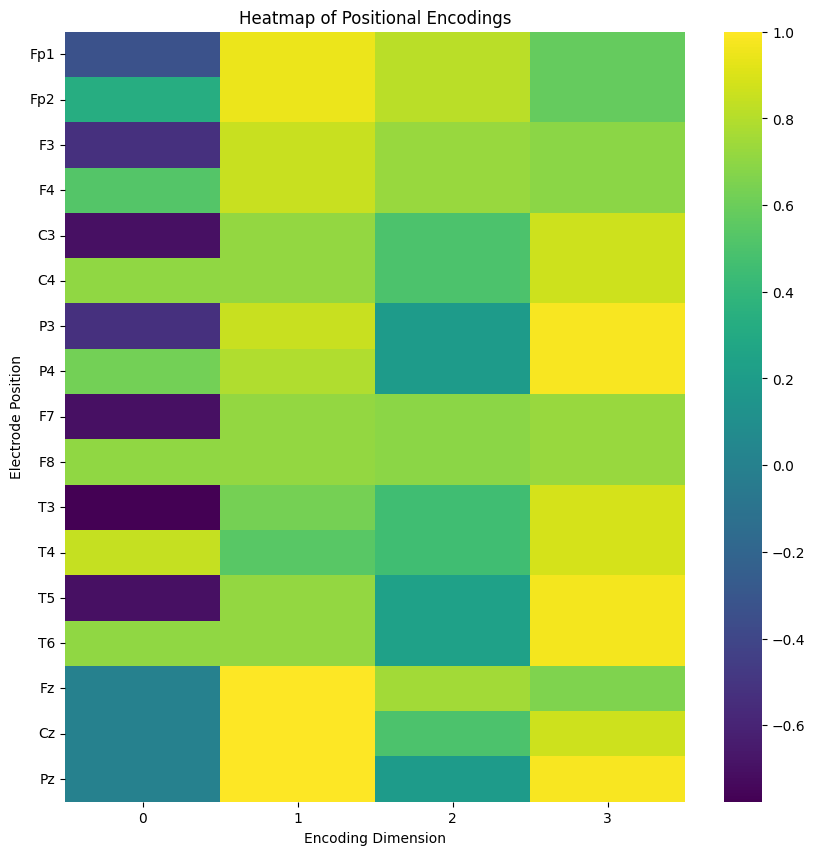

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

test_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

d_model = 4
encodings = [positionalencoding2d(d_model, x, y) for x, y in zip((normalized_ch_pos[name][0] for name in test_channels), (normalized_ch_pos[name][1] for name in test_channels))]
embeddings= np.stack(encodings)
# Plot a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(embeddings, cmap='viridis')

plt.title('Heatmap of Positional Encodings')
plt.xlabel('Encoding Dimension')
ax = plt.gca()
ax.set_yticklabels(test_channels, rotation=0)
plt.ylabel('Electrode Position')
plt.show()

**Visualizing the encoding shows that the x symmetry is preserved in the first dimension, Now let's use PCA to reconstruct the space and compare with montage plot**

(17, 3)


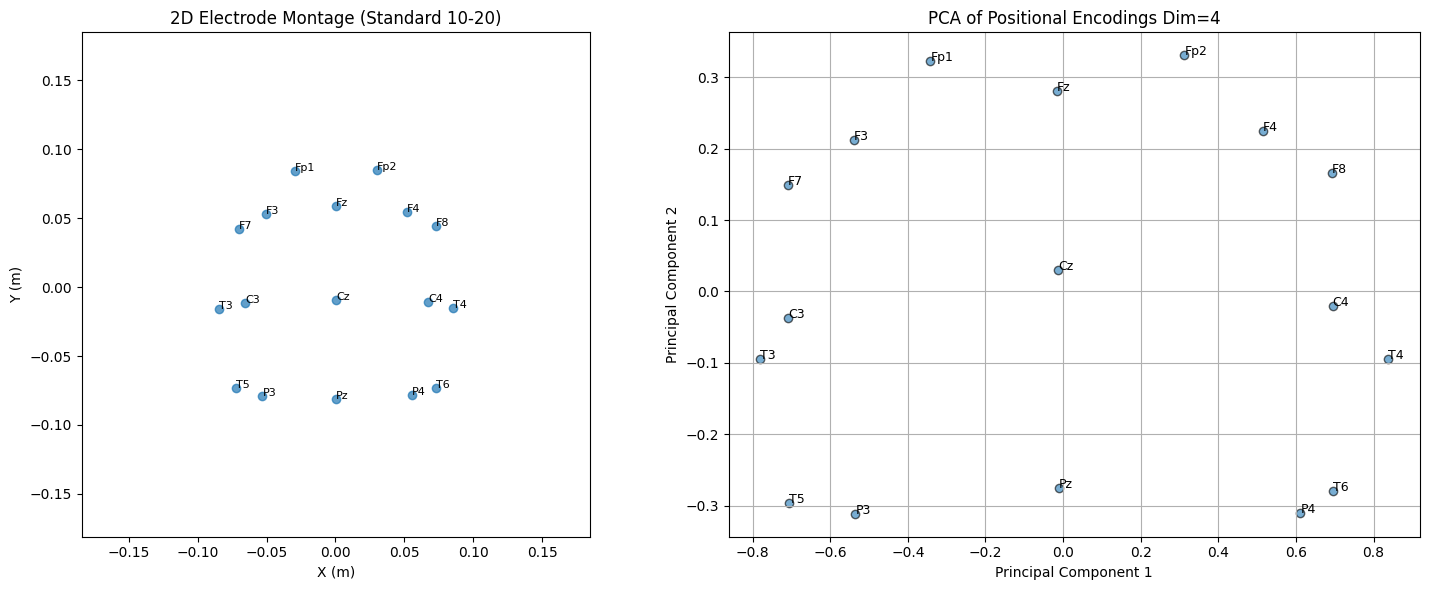

In [37]:
from sklearn.decomposition import PCA

# Compare the embedding with original montage plot
pos = montage.get_positions()['ch_pos']

x, y = zip(*[(pos[ch][0], pos[ch][1]) for ch in test_channels])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot original montage
axs[0].scatter(x, y, alpha=0.7)

for i, ch_name in enumerate(test_channels):
    axs[0].text(x[i], y[i], ch_name, fontsize=8)

axs[0].set_xlim(min(x) - 0.1, max(x) + 0.1)
axs[0].set_ylim(min(y) - 0.1, max(y) + 0.1)

axs[0].set_aspect('equal', adjustable='box')

axs[0].set_xlabel('X (m)')
axs[0].set_ylabel('Y (m)')

axs[0].set_title('2D Electrode Montage (Standard 10-20)')

# Plot PCA of positional encodings
encodings = [positionalencoding2d(d_model, x, y) for x, y in zip((normalized_ch_pos[name][0] for name in test_channels), (normalized_ch_pos[name][1] for name in test_channels))]

# Convert your list of encodings to a 2D array if it's not already
encodings_array = np.stack(encodings)[:,:3]
print(encodings_array.shape)

# Initialize PCA, we'll reduce to two components for 2D visualization
pca = PCA(n_components=2)

# Fit PCA on the positional encodings and transform the data
encodings_pca = pca.fit_transform(encodings_array)

# Plot the first two principal components
axs[1].scatter(encodings_pca[:, 0], encodings_pca[:, 1], edgecolor='k', alpha=0.6)

for i, label in enumerate(test_channels):
    axs[1].text(encodings_pca[i, 0], encodings_pca[i, 1], label, fontsize=9)

axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_title('PCA of Positional Encodings Dim=4')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [213]:
import pandas as pd
semanticmatrix = pd.read_csv('semanticmatrix.csv')

In [215]:
locations = semanticmatrix.columns.tolist()
locations

['(29, (29, 361))/(34, (722.0, 361))',
 '(30, (160, 197))/(35, (591.0, 197))',
 '(31, (219, 164))/(36, (532.0, 164))',
 '(32, (271, 186))/(37, (480.0, 186))',
 '(33, (317, 245))/(38, (434.0, 245))']

In [216]:
# geting the annotated id and the coordinates
data = [{str(int(part.split(',')[0].replace('(', ''))): np.array([float(coord.replace('(', '').replace(')', '')) for coord in part.split(',')[1:]]).reshape(-1, 1) for part in item.split('/')} for item in locations]
semantic_dic = {k: v for d in data for k, v in d.items()}
data_values = list(semantic_dic.values())
names = list(semantic_dic.keys())
xy_positions = [arr.flatten().tolist() for arr in data_values]

In [223]:
#adapt the NW coordinates system from the interface
data =np.array(xy_positions[:])
# Calculate the midpoints for x and y
mid_x = (data[:, 0].max() + data[:, 0].min()) / 2
mid_y = (data[:, 1].max() + data[:, 1].min()) / 2

# Subtract the midpoints from the coordinates
data[:, 0] -= mid_x
data[:, 1] -= mid_y
data[:, 1] = -data[:, 1]

In [ ]:
# Normalize x coordinates using the maximum absolute value to preserve symmetry
xy_positions = data.tolist()
x_vals =  [row[0] for row in xy_positions]
x_vals_abs_max = np.max(np.abs(x_vals))  # Find the maximum absolute value for x
x_normalized = x_vals / x_vals_abs_max  # Normalize by the absolute max value

# Normalize y coordinates using standard min-max normalization
y_vals = [row[1] for row in xy_positions]
y_min, y_max = np.min(y_vals), np.max(y_vals)
y_normalized = (y_vals - y_min) / (y_max - y_min)  # Scale y to [0, 1] range

# Combine normalized x and y back into a structure
normalized_positions = np.vstack((x_normalized, y_normalized)).T
# Update the OrderedDict with normalized positions, excluding z
normalized_sem_pos = OrderedDict()
for key, norm_pos in zip(list(semantic_dic.keys()), normalized_positions):
    normalized_sem_pos[key] = np.array(norm_pos)

In [235]:
normalized_sem_pos

OrderedDict([('29', array([-1.,  0.])),
             ('34', array([1., 0.])),
             ('30', array([-0.62193362,  0.83248731])),
             ('35', array([0.62193362, 0.83248731])),
             ('31', array([-0.45165945,  1.        ])),
             ('36', array([0.45165945, 1.        ])),
             ('32', array([-0.3015873 ,  0.88832487])),
             ('37', array([0.3015873 , 0.88832487])),
             ('33', array([-0.16883117,  0.58883249])),
             ('38', array([0.16883117, 0.58883249]))])

In [ ]:
with open('normalized_sem_pos.pkl', 'wb') as f:
    pickle.dump(normalized_sem_pos, f)

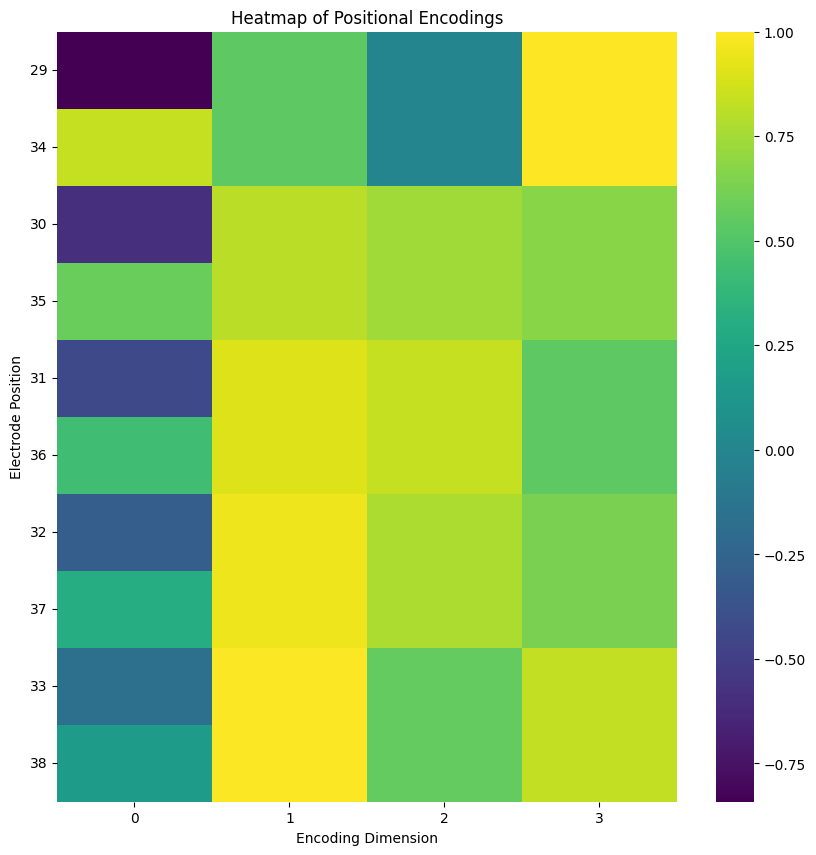

In [238]:
#every two rows represent same finger of both hands
test_channels = list(semantic_dic.keys())
d_model = 4
encodings = [positionalencoding2d(d_model, x, y) for x, y in zip((normalized_ch_pos[name][0] for name in test_channels), (normalized_ch_pos[name][1] for name in test_channels))]
embeddings= np.stack(encodings)[:,:4]
# Plot a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(embeddings, cmap='viridis')

plt.title('Heatmap of Positional Encodings')
plt.xlabel('Encoding Dimension')
ax = plt.gca()
ax.set_yticklabels(test_channels, rotation=0)
plt.ylabel('Electrode Position')
plt.show()

(10, 4)


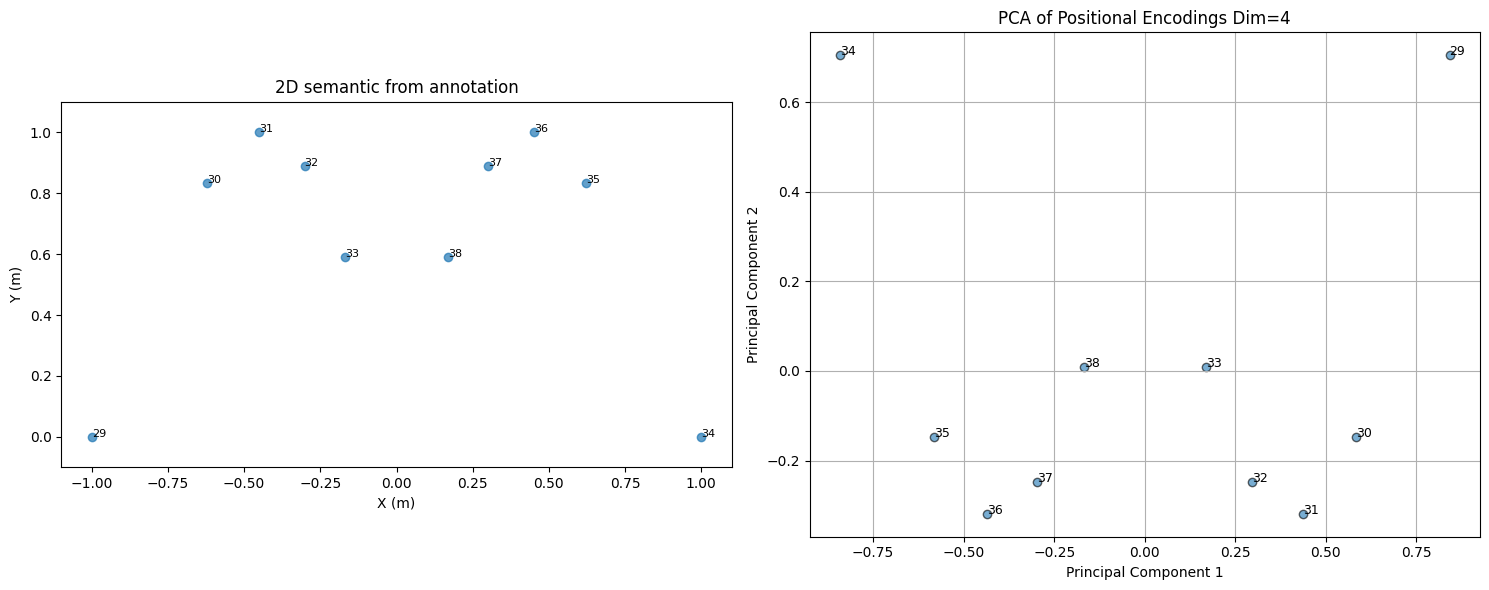

In [240]:
# Now we can compare the original semantic plot with the PCA of the positional encodings

from sklearn.decomposition import PCA

# Compare the embedding with original montage plot
pos = normalized_sem_pos

x, y = zip(*[(pos[ch][0], pos[ch][1]) for ch in test_channels])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot original montage
axs[0].scatter(x, y, alpha=0.7)

for i, ch_name in enumerate(test_channels):
    axs[0].text(x[i], y[i], ch_name, fontsize=8)

axs[0].set_xlim(min(x) - 0.1, max(x) + 0.1)
axs[0].set_ylim(min(y) - 0.1, max(y) + 0.1)

axs[0].set_aspect('equal', adjustable='box')

axs[0].set_xlabel('X (m)')
axs[0].set_ylabel('Y (m)')

axs[0].set_title('2D semantic from annotation')

# Plot PCA of positional encodings
encodings = [positionalencoding2d(d_model, x, y) for x, y in zip((normalized_sem_pos[name][0] for name in test_channels), (normalized_sem_pos[name][1] for name in test_channels))]

# Convert your list of encodings to a 2D array if it's not already
encodings_array = np.stack(encodings)[:,:4]
print(encodings_array.shape)

# Initialize PCA, we'll reduce to two components for 2D visualization
pca = PCA(n_components=2)

# Fit PCA on the positional encodings and transform the data
encodings_pca = pca.fit_transform(encodings_array)

# Plot the first two principal components
axs[1].scatter(encodings_pca[:, 0], encodings_pca[:, 1], edgecolor='k', alpha=0.6)

for i, label in enumerate(test_channels):
    axs[1].text(encodings_pca[i, 0], encodings_pca[i, 1], label, fontsize=9)

axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_title('PCA of Positional Encodings Dim=4')
axs[1].grid(True)

plt.tight_layout()
plt.show()


**Edge Embedding**

In [241]:

def combine_positional_encodings(encoding1, encoding2):
    """
    Combines two high-dimensional positional encodings to represent the relationship
    between two points as a vector in the same high-dimensional space.
    
    Args:
    - encoding1 (torch.Tensor): The positional encoding for the first point.
    - encoding2 (torch.Tensor): The positional encoding for the second point.
    
    Returns:
    - torch.Tensor: The combined encoding representing the vector between two points.
    """
    # Example of combining two encodings by subtraction to get a directional vector
    vector_encoding = encoding2 - encoding1
    return vector_encoding


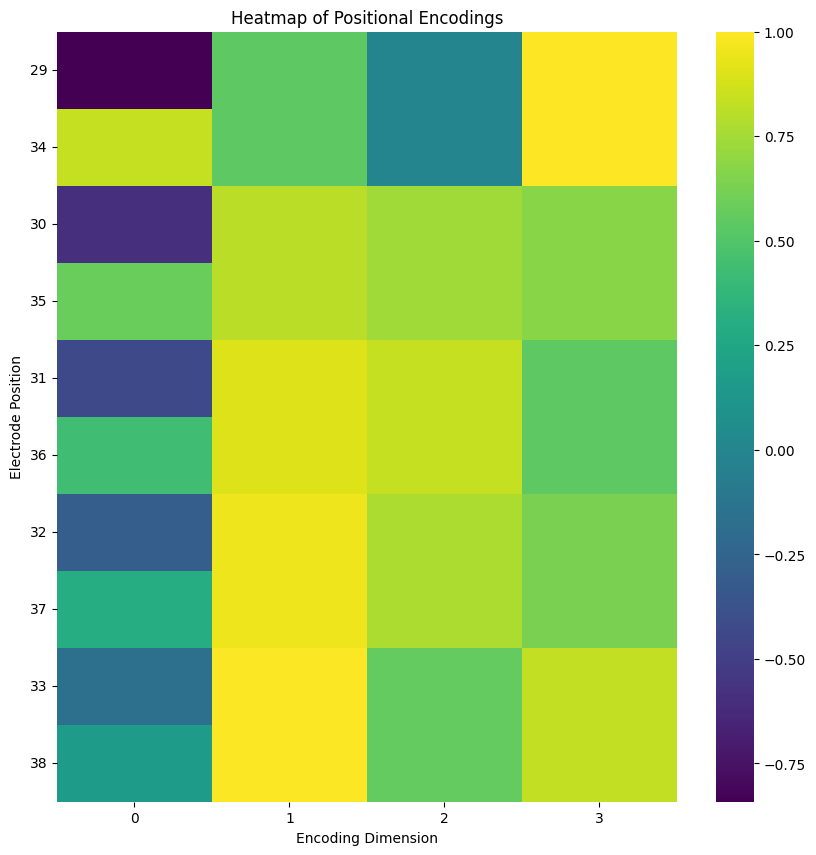

In [329]:
test_channels = list(semantic_dic.keys())
d_model = 4
encodings = [positionalencoding2d(d_model, x, y) for x, y in zip((normalized_ch_pos[name][0] for name in test_channels), (normalized_ch_pos[name][1] for name in test_channels))]
embeddings= np.stack(encodings)[:,:4]
# Plot a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(embeddings, cmap='viridis')

plt.title('Heatmap of Positional Encodings')
plt.xlabel('Encoding Dimension')
ax = plt.gca()
ax.set_yticklabels(test_channels, rotation=0)
plt.ylabel('Electrode Position')
plt.show()

**Visualize edge embedding**

In [260]:
vector_encodings = []
lefts = []
rights = []
label = []
for i in range(0, len(test_channels), 2):
    left = test_channels[i]
    right = test_channels[i + 1]
    lefts.append(len(lefts))
    rights.append(len(rights))
    label.append(str(lefts[-1]) + '-' + str(rights[-1]))
   
    vector = combine_positional_encodings(encodings[i+1], encodings[i])
    vector_encodings.append(vector)

In [334]:
edge_embeddings = np.stack(vector_encodings)
print(edge_embeddings.shape)
positional_embeddings = np.stack(encodings)
print(positional_embeddings.shape)
combined_data = np.vstack((edge_embeddings, positional_embeddings))
print(combined_data.shape)

(5, 4)
(10, 4)
(15, 4)


In [335]:
labels = lefts + rights+ label 
labels

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, '0-0', '1-1', '2-2', '3-3', '4-4']

**Visualizing the linear relationship of the opposite finger edge embeddings using PCA**

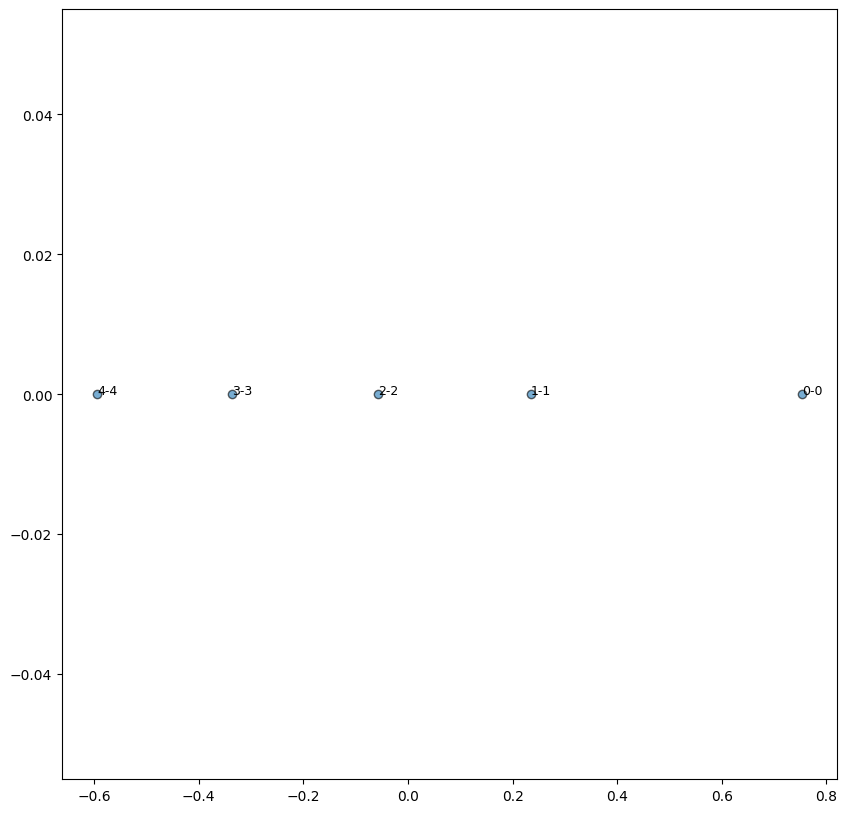

In [327]:
pca = PCA(n_components=2)  # For 2D visualization
reduced_data = pca.fit_transform(edge_embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], edgecolor='k', alpha=0.6)

for i, labl in enumerate(label):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], labl, fontsize=9)

**Using T-SNE to visualize the non-linear relationship between egdes and nodes**

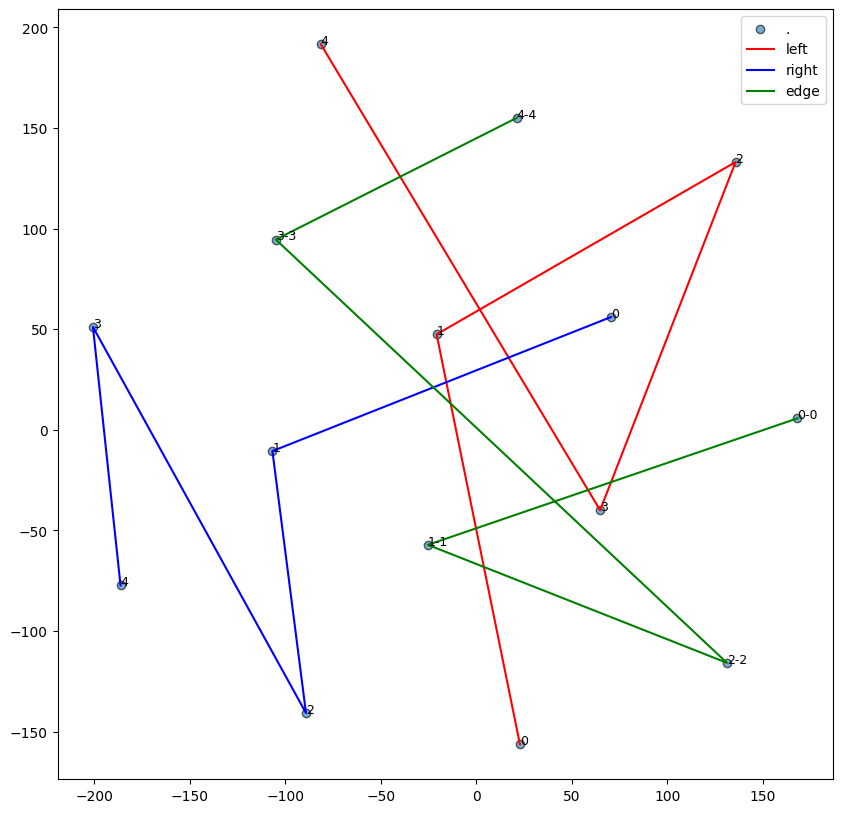

In [345]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=14)
tsne_data = tsne.fit_transform(combined_data)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], edgecolor='k', alpha=0.6)

colors = ['r', 'b', 'g']

for i in range(0, len(labels), 5):
    color = colors[i//5]  
    plt.plot(tsne_data[i:i+5, 0], tsne_data[i:i+5, 1], color=color, label=labels[i:i+5])

plt.legend(['.','left', 'right', 'edge'])

for i, labl in enumerate(labels):
    plt.text(tsne_data[i, 0], tsne_data[i, 1], labl, fontsize=9)

